In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

file_path = "Hr1m.csv"
df = pd.read_csv(file_path)

df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
df['Date of Joining'] = pd.to_datetime(df['Date of Joining'], errors='coerce')



In [2]:
df['Year of Joining'] = df['Date of Joining'].dt.year
df['Month of Joining'] = df['Date of Joining'].dt.month
df['Quarter of Joining'] = df['Date of Joining'].dt.quarter
df['DOW of Joining'] = df['Date of Joining'].dt.dayofweek
df['Experience Mismatch'] = df['Age in Company (Years)'] - (df['Date of Joining'].dt.year - df['Date of Birth'].dt.year)
df['Salary per Year'] = df['Salary'] / df['Age in Company (Years)']
df['Last % Hike'] = df['Last % Hike'].str.replace('%', '').astype(float)


np.random.seed(42)
df['Attrition'] = 0

rule1_mask = (df['Age in Company (Years)'] > 5) & (df['Last % Hike'] < 5)
df.loc[rule1_mask, 'Attrition'] = np.random.choice([0, 1], size=rule1_mask.sum(), p=[0.2, 0.8])

rule2_mask = (df['Last % Hike'] > 20)
df.loc[rule2_mask, 'Attrition'] = np.random.choice([0, 1], size=rule2_mask.sum(), p=[0.3, 0.7])

rule3_mask = (df['Salary'] < df['Salary'].quantile(0.25)) & (df['Age in Company (Years)'] > 3)
df.loc[rule3_mask, 'Attrition'] = np.random.choice([0, 1], size=rule3_mask.sum(), p=[0.4, 0.6])

rule4_mask = (df['Year of Joining'] > 2020) & (df['Last % Hike'] > 15)
df.loc[rule4_mask, 'Attrition'] = np.random.choice([0, 1], size=rule4_mask.sum(), p=[0.5, 0.5])

df = df.drop_duplicates()

In [3]:
scaler = MinMaxScaler()
df[['Salary', 'Last % Hike']] = scaler.fit_transform(df[['Salary', 'Last % Hike']])

le = LabelEncoder()
df['Region'] = le.fit_transform(df['Region'])

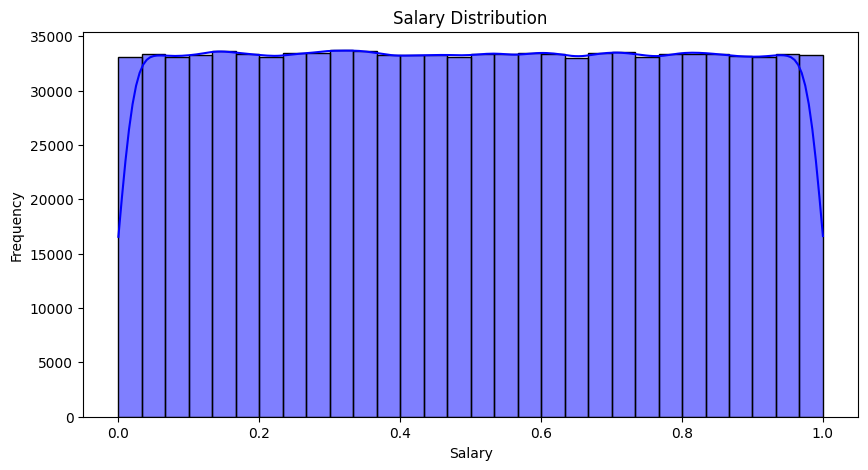

C:\Users\saira\AppData\Local\Temp\ipykernel_25760\229699642.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Attrition'], palette='coolwarm')


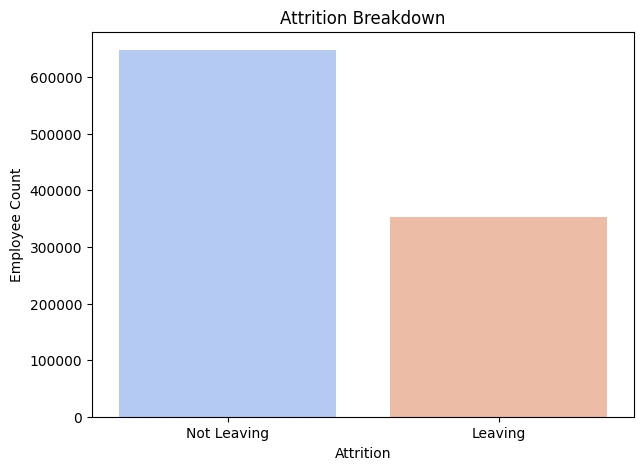

C:\Users\saira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


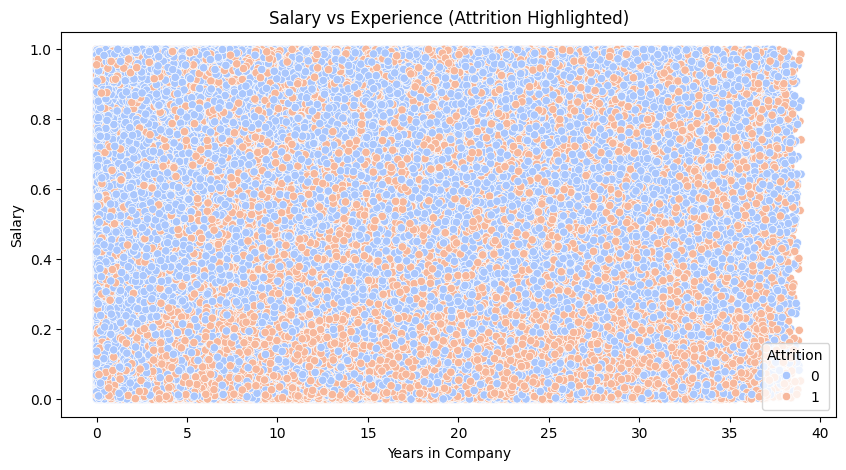

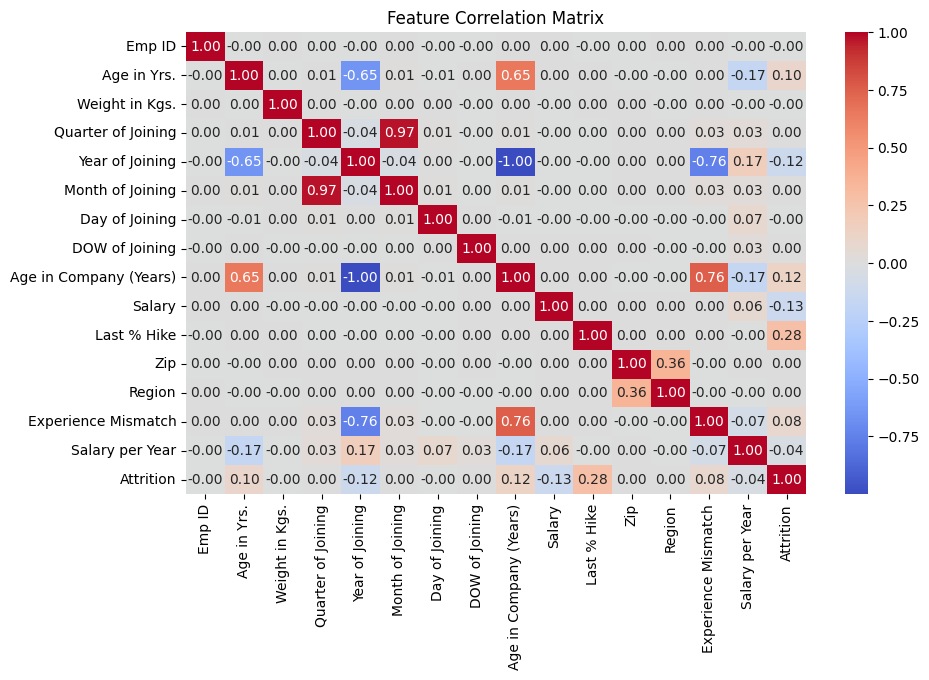

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Salary'], bins=30, kde=True, color='blue')
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(7, 5))
sns.countplot(x=df['Attrition'], palette='coolwarm')
plt.title("Attrition Breakdown")
plt.xticks(ticks=[0, 1], labels=['Not Leaving', 'Leaving'])
plt.ylabel('Employee Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Age in Company (Years)'], y=df['Salary'], hue=df['Attrition'], palette='coolwarm')
plt.title('Salary vs Experience (Attrition Highlighted)')
plt.xlabel('Years in Company')
plt.ylabel('Salary')
plt.show()

numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Accuracy: 0.801015
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84    129462
           1       0.69      0.80      0.74     70538

    accuracy                           0.80    200000
   macro avg       0.78      0.80      0.79    200000
weighted avg       0.81      0.80      0.80    200000



C:\Users\saira\AppData\Local\Temp\ipykernel_25760\803098888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clf.feature_importances_, y=X.columns, palette="viridis")


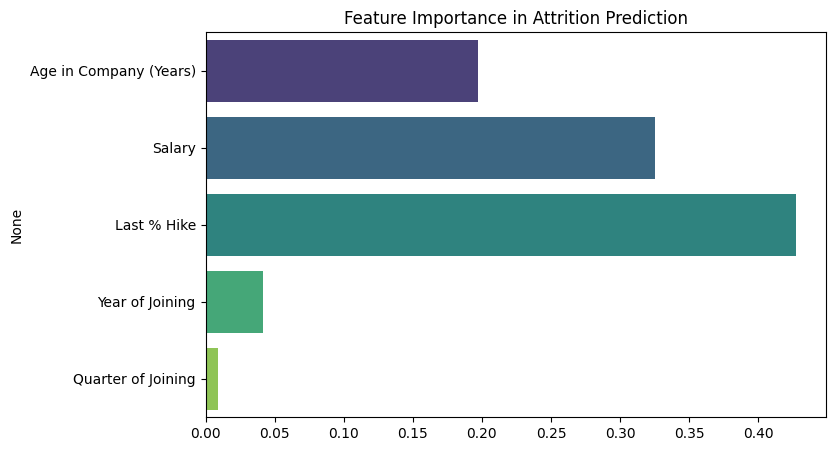

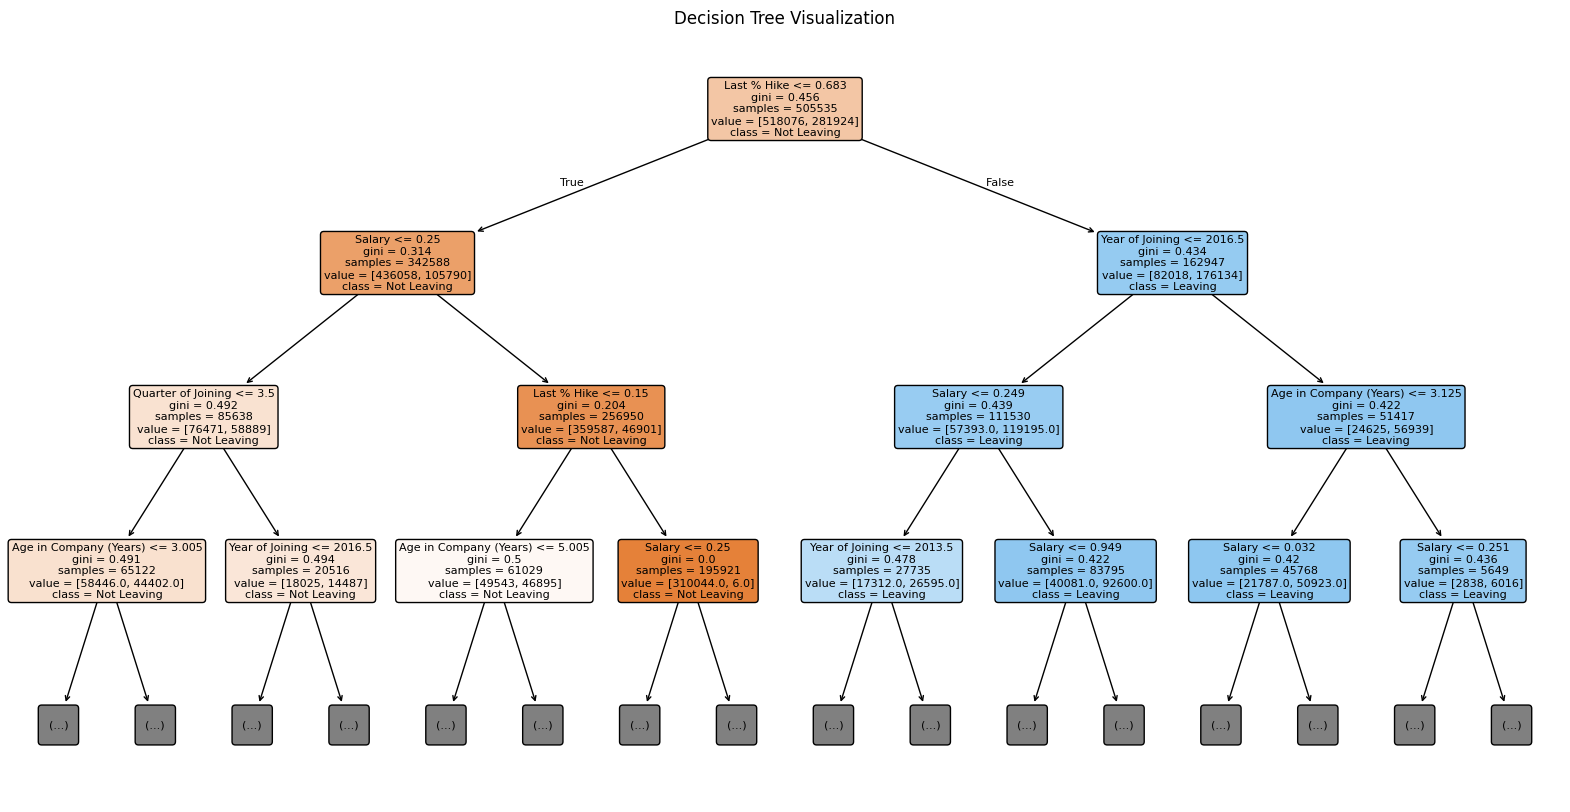

In [5]:
X = df[['Age in Company (Years)', 'Salary', 'Last % Hike', 'Year of Joining', 'Quarter of Joining']]
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(8, 5))
sns.barplot(x=clf.feature_importances_, y=X.columns, palette="viridis")
plt.title("Feature Importance in Attrition Prediction")
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(clf.estimators_[0], feature_names=X.columns, class_names=['Not Leaving', 'Leaving'],
          filled=True, rounded=True, fontsize=8, max_depth=3)
plt.title("Decision Tree Visualization")
plt.show()

Potential Fraudulent Employees: 50000


C:\Users\saira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


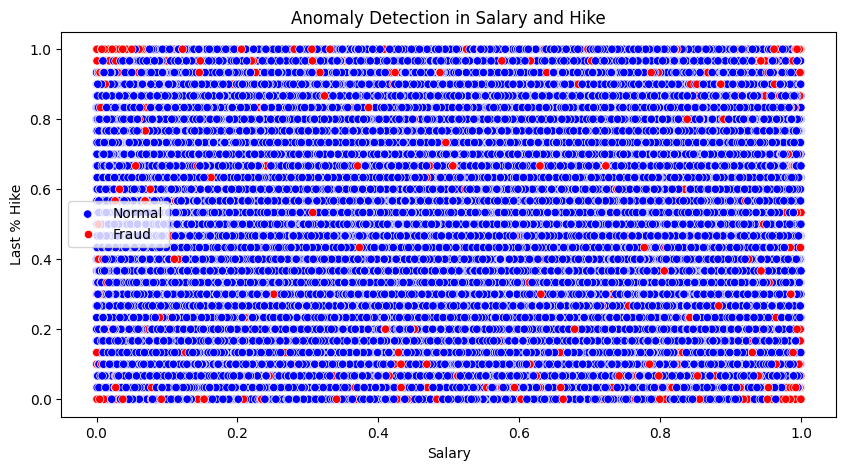

In [6]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Fraud_Score'] = iso_forest.fit_predict(df[['Salary', 'Last % Hike', 'Experience Mismatch']])
fraudulent_employees = df[df['Fraud_Score'] == -1]

print(f"Potential Fraudulent Employees: {len(fraudulent_employees)}")

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Salary'], y=df['Last % Hike'], hue=df['Fraud_Score'], palette={1: 'blue', -1: 'red'})
plt.title("Anomaly Detection in Salary and Hike")
plt.xlabel('Salary')
plt.ylabel('Last % Hike')
plt.legend(['Normal', 'Fraud'])
plt.show()


XGBoost Accuracy: 0.833415
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    129462
           1       0.68      1.00      0.81     70538

    accuracy                           0.83    200000
   macro avg       0.84      0.87      0.83    200000
weighted avg       0.89      0.83      0.84    200000


Feature Importances:
               Feature  Importance
           Last % Hike    0.640243
Age in Company (Years)    0.214295
                Salary    0.139708
    Quarter of Joining    0.002885
       Year of Joining    0.002869


C:\Users\saira\AppData\Local\Temp\ipykernel_25760\2433955380.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


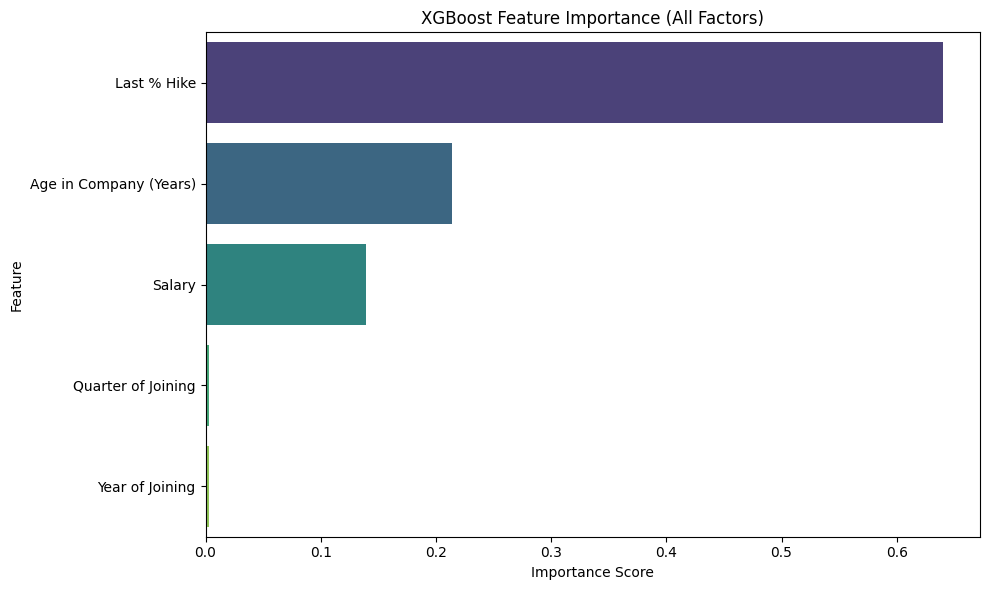

In [7]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print("\nXGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

feature_importance = xgb_clf.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

importance_df = pd.DataFrame({
    'Feature': X.columns[sorted_idx],
    'Importance': feature_importance[sorted_idx]
})

print("\nFeature Importances:")
print(importance_df.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("XGBoost Feature Importance (All Factors)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [8]:
models = {
    'Random Forest': clf,
    'XGBoost': xgb_clf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    print(f"{name} - AUC: {auc:.3f}")

Random Forest - AUC: 0.802
XGBoost - AUC: 0.870


Decision Tree Accuracy: 0.833105
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85    129462
           1       0.68      0.99      0.81     70538

    accuracy                           0.83    200000
   macro avg       0.84      0.87      0.83    200000
weighted avg       0.88      0.83      0.84    200000



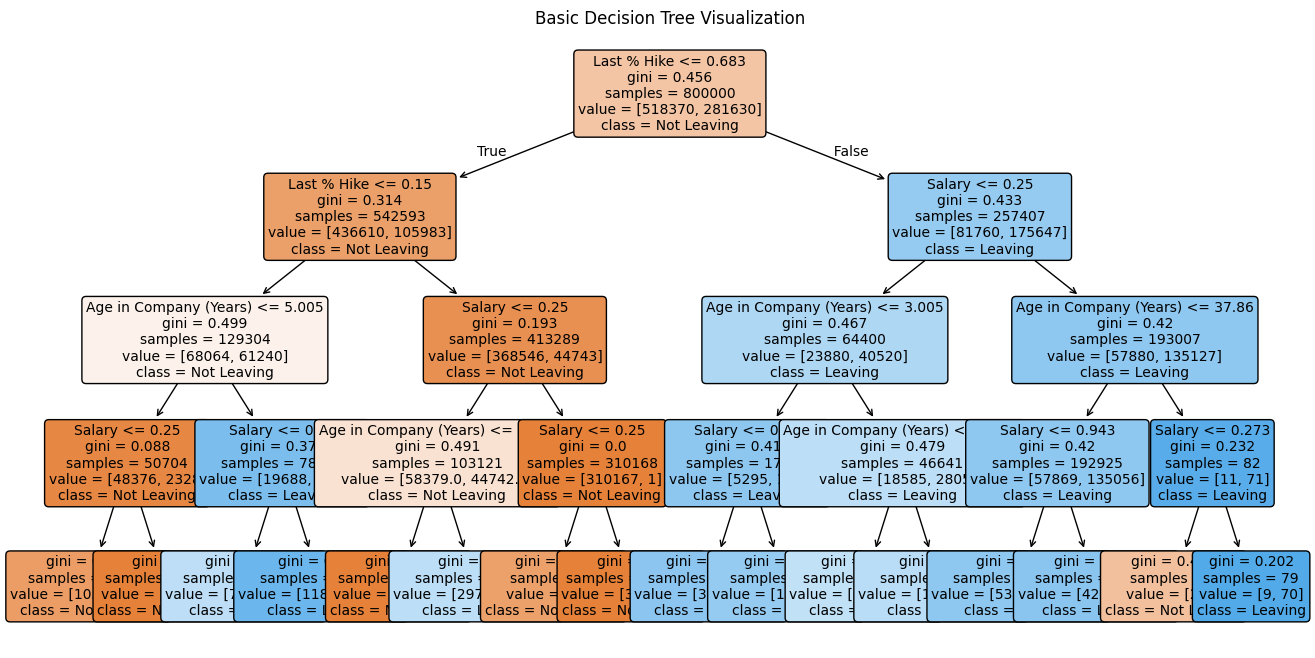

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# Visualize the tree
plt.figure(figsize=(16, 8))
plot_tree(dt_clf, feature_names=X.columns, class_names=['Not Leaving', 'Leaving'],
          filled=True, rounded=True, fontsize=10)
plt.title("Basic Decision Tree Visualization")
plt.show()


In [10]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.699535
              precision    recall  f1-score   support

           0       0.72      0.88      0.79    129462
           1       0.63      0.36      0.46     70538

    accuracy                           0.70    200000
   macro avg       0.67      0.62      0.63    200000
weighted avg       0.69      0.70      0.67    200000



In [11]:
# from sklearn.svm import SVC

# svc_clf = SVC(kernel='rbf', probability=True)
# svc_clf.fit(X_train, y_train)
# y_pred_svc = svc_clf.predict(X_test)

# print("SVM Accuracy:", accuracy_score(y_test, y_pred_svc))
# print(classification_report(y_test, y_pred_svc))


In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.79734
              precision    recall  f1-score   support

           0       0.87      0.80      0.84    129462
           1       0.69      0.79      0.73     70538

    accuracy                           0.80    200000
   macro avg       0.78      0.79      0.78    200000
weighted avg       0.81      0.80      0.80    200000



Logistic Regression Accuracy: 0.6995
              precision    recall  f1-score   support

           0       0.72      0.88      0.79    129462
           1       0.63      0.36      0.46     70538

    accuracy                           0.70    200000
   macro avg       0.67      0.62      0.63    200000
weighted avg       0.69      0.70      0.67    200000

--------------------------------------------------
Decision Tree Accuracy: 0.8331
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    129462
           1       0.68      0.99      0.81     70538

    accuracy                           0.83    200000
   macro avg       0.84      0.87      0.83    200000
weighted avg       0.88      0.83      0.84    200000

--------------------------------------------------
Random Forest Accuracy: 0.8014
              precision    recall  f1-score   support

           0       0.88      0.80      0.84    129462
           1       0.69      0.80   

C:\Users\saira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [05:39:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8334
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    129462
           1       0.68      1.00      0.81     70538

    accuracy                           0.83    200000
   macro avg       0.84      0.87      0.83    200000
weighted avg       0.89      0.83      0.84    200000

--------------------------------------------------


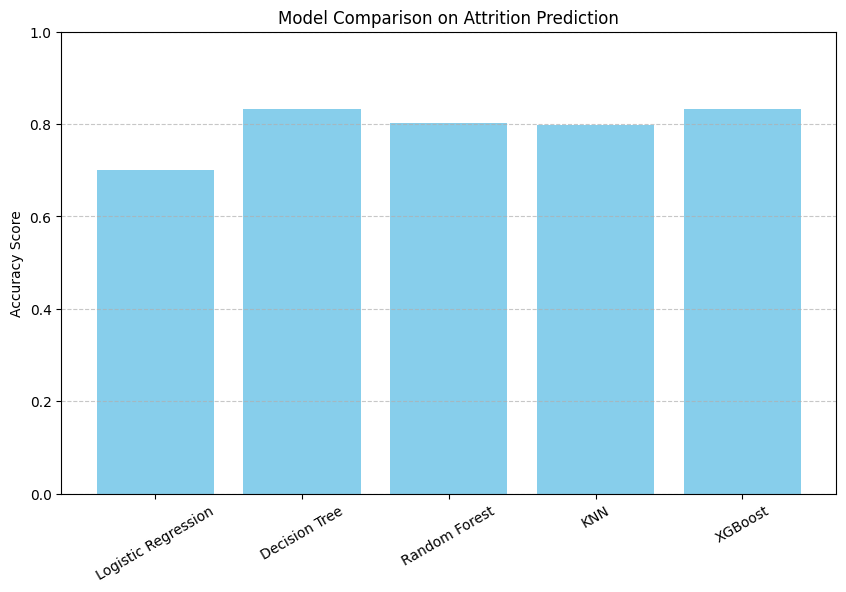

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=4),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    # "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.title("Model Comparison on Attrition Prediction")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [17]:
def predict_attrition(age_in_company, salary, last_hike_percent, year_of_joining, quarter_of_joining):
    """
    Predict if an employee will leave based on input features.
    Parameters should be provided in raw format (not scaled).
    """
    # Scale salary and hike (same scaler used during training)
    salary_scaled = scaler.transform([[salary, last_hike_percent]])[0]

    # Create input dataframe
    input_data = pd.DataFrame([[
        age_in_company,
        salary_scaled[0],
        salary_scaled[1],
        year_of_joining,
        quarter_of_joining
    ]], columns=['Age in Company (Years)', 'Salary', 'Last % Hike', 'Year of Joining', 'Quarter of Joining'])

    # Predict
    prediction = clf.predict(input_data)[0]
    probability = clf.predict_proba(input_data)[0][prediction]

    label = "Leaving" if prediction == 1 else "Not Leaving"
    print(f"Prediction: {label} (Confidence: {probability * 100:.2f}%)")

# Example usage
predict_attrition(
    age_in_company=4,
    salary=60000,
    last_hike_percent=3.5,
    year_of_joining=2021,
    quarter_of_joining=2
)


Prediction: Not Leaving (Confidence: 69.00%)


C:\Users\saira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [18]:
def detect_salary_anomaly(salary, df):
    q1 = df['Salary'].quantile(0.25)
    q3 = df['Salary'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    if salary < lower_bound:
        return "Below normal (anomaly)"
    elif salary > upper_bound:
        return "Above normal (anomaly)"
    else:
        return "Normal"


<Axes: xlabel='Salary', ylabel='Last % Hike'>

C:\Users\saira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\saira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


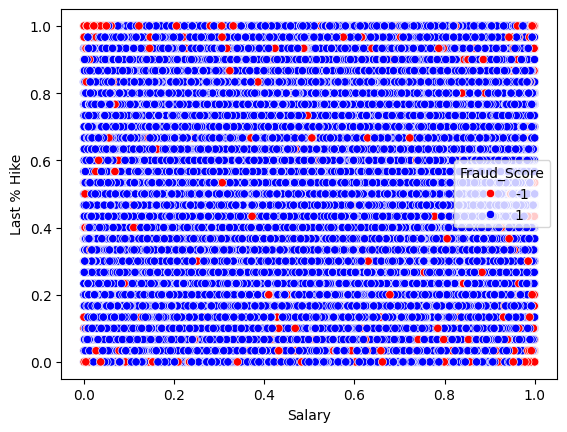

In [19]:
sns.scatterplot(x=df['Salary'], y=df['Last % Hike'], hue=df['Fraud_Score'], palette={1: 'blue', -1: 'red'})


In [20]:
def check_employee_fraud(salary, last_hike, exp_mismatch):
    data = [[salary, last_hike, exp_mismatch]]
    result = iso_forest.predict(data)
    return "Fraudulent" if result[0] == -1 else "Normal"


In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 🔹 Step 1: Load original (unscaled) dataset from CSV
df_new = pd.read_csv("Hr1m.csv")

# 🔹 Convert 'Date of Joining' and 'Date of Birth' to datetime if they aren't already
df_new['Date of Joining'] = pd.to_datetime(df_new['Date of Joining'], errors='coerce')
df_new['Date of Birth'] = pd.to_datetime(df_new['Date of Birth'], errors='coerce')

# 🔹 Calculate 'Experience Mismatch'
df_new['Experience Mismatch'] = df_new['Age in Company (Years)'] - (df_new['Date of Joining'].dt.year - df_new['Date of Birth'].dt.year)

# 🧼 Optional: Select only relevant columns for scaling
features_to_scale = ['Salary', 'Last % Hike', 'Experience Mismatch']

# Convert 'Last % Hike' column to numeric by removing '%' and converting to float
df_new['Last % Hike'] = df_new['Last % Hike'].replace('%', '', regex=True).astype(float)

# Now select the relevant data for scaling
original_data = df_new[features_to_scale]

# 🔹 Step 2: Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(original_data)

# 🔹 Step 3: Scale your training data
scaled_training = scaler.transform(original_data)
scaled_train_df = pd.DataFrame(scaled_training, columns=features_to_scale)

# 🔹 Step 4: New employee data (raw)
new_employee_input = pd.DataFrame({
    'Salary': [105000],
    'Last % Hike': [25],
    'Experience Mismatch': [0.5]
})

# 🔹 Step 5: Scale new employee data
scaled_new_input = scaler.transform(new_employee_input)
scaled_new_df = pd.DataFrame(scaled_new_input, columns=features_to_scale)

# 🔍 Output
print("🔎 Scaled Training Data:\n", scaled_train_df.head())
print("\n🔍 Scaled New Employee Input:\n", scaled_new_df)

# 🔹 Step 6: Predict if the profile is an anomaly using Isolation Forest
iso_forest = IsolationForest(contamination=0.1)  # Adjust contamination rate as needed
iso_forest.fit(scaled_train_df)

# Predict whether the new employee is an anomaly
prediction = iso_forest.predict(scaled_new_input)

# 🔹 Step 7: Interpret the prediction
if prediction[0] == -1:
    print("⚠️ Potential Fraudulent Profile")
else:
    print("✅ Profile Seems Normal")

# 🔹 Step 8: Weighted Sum Approach (if you want a custom fraudulence score)
# Assign custom weights to features, e.g., Salary: 0.5, Last % Hike: 0.3, Experience Mismatch: 0.2
weights = {
    'Salary': 0.5,
    'Last % Hike': 0.3,
    'Experience Mismatch': 0.2
}

# Compute a weighted sum score for the new employee
weighted_score = (scaled_new_input[0][0] * weights['Salary'] +
                  scaled_new_input[0][1] * weights['Last % Hike'] +
                  scaled_new_input[0][2] * weights['Experience Mismatch'])

# Define a threshold for fraudulent behavior (you can adjust this threshold as needed)
threshold = 0.5

# Check if the weighted score exceeds the threshold, indicating fraud
if weighted_score > threshold:
    print(f"⚠️ High Fraud Risk (Weighted Score: {weighted_score:.2f})")
else:
    print(f"✅ Low Fraud Risk (Weighted Score: {weighted_score:.2f})")


🔎 Scaled Training Data:
      Salary  Last % Hike  Experience Mismatch
0  0.672569     0.700000             0.559805
1  0.133469     0.633333             0.854979
2  0.401081     0.333333             0.465477
3  0.584756     0.400000             0.436345
4  0.261694     0.800000             0.503080

🔍 Scaled New Employee Input:
     Salary  Last % Hike  Experience Mismatch
0  0.40625     0.833333             0.776309
✅ Profile Seems Normal
⚠️ High Fraud Risk (Weighted Score: 0.61)


C:\Users\saira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


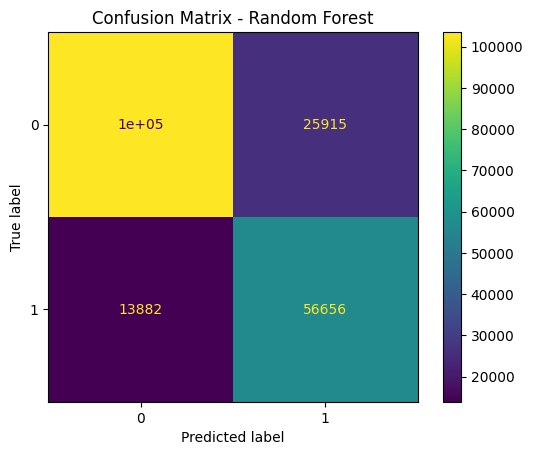

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming `clf` is your RandomForestClassifier
y_pred_rf = clf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=clf.classes_)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()



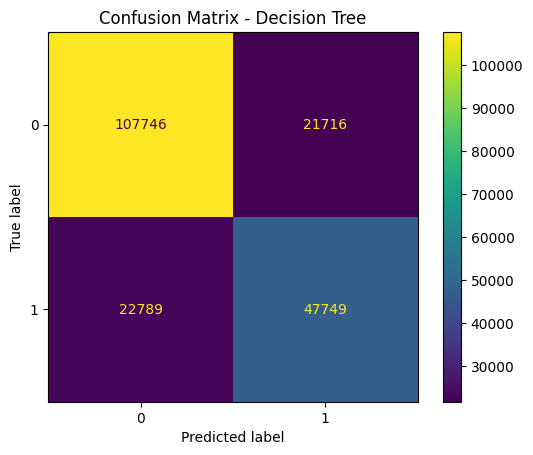

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree for comparison
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_)
disp_dt.plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()


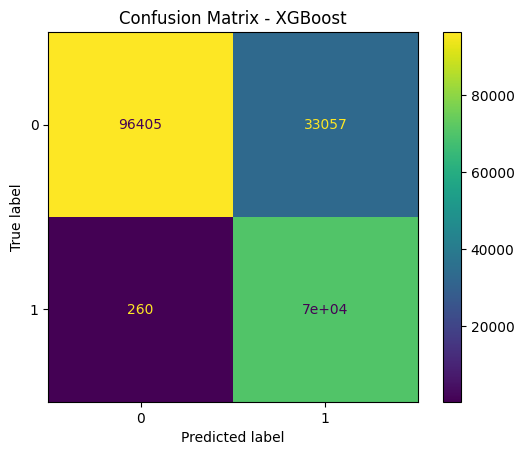

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the XGBoost classifier
y_pred_xgb = xgb_clf.predict(X_test)

# Compute and display confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_clf.classes_)
disp_xgb.plot()
plt.title("Confusion Matrix - XGBoost")
plt.show()

